In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [65]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re
import itertools

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

### Load validation predicted probabilities

In [3]:
main_dir = '/tf/notebooks/'

In [4]:
probs_path = main_dir+'final-project/Classification/data/ethnicity'

In [5]:
val_pred_probs_mlp_ngram = np.load(os.path.join(probs_path, 'val_pred_probs_mlp_ngram.npy'))
val_pred_probs_cnn = np.load(os.path.join(probs_path, 'val_pred_probs_cnn.npy'))
val_pred_probs_cnn_aggr_chunk = np.load(os.path.join(probs_path, 'val_pred_probs_cnn_aggr_chunk.npy'))

In [6]:
len(val_pred_probs_mlp_ngram), len(val_pred_probs_cnn), len(val_pred_probs_cnn_aggr_chunk)

(62840, 62840, 62840)

In [7]:
with open(os.path.join(probs_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(probs_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)
with open(os.path.join(probs_path, 'val_list'), 'rb') as fp:
    val_list = pickle.load(fp)

In [8]:
len(val_ids), len(val_target), len(val_list)

(62840, 62840, 62840)

In [9]:
val_preds_mlp_ngram = val_pred_probs_mlp_ngram > 0.5
val_preds_cnn = val_pred_probs_cnn > 0.5
val_preds_cnn_aggr_chunk = val_pred_probs_cnn_aggr_chunk > 0.5

In [10]:
sum(val_preds_mlp_ngram), sum(val_preds_cnn), sum(val_preds_cnn_aggr_chunk)

(array([29212]), array([30823]), 31133)

In [11]:
classes = ['White', 'NonWhite']

Confusion matrix, without normalization
[[24863  6557]
 [ 8765 22655]]
              precision    recall  f1-score   support

       White       0.74      0.79      0.76     31420
    NonWhite       0.78      0.72      0.75     31420

   micro avg       0.76      0.76      0.76     62840
   macro avg       0.76      0.76      0.76     62840
weighted avg       0.76      0.76      0.76     62840



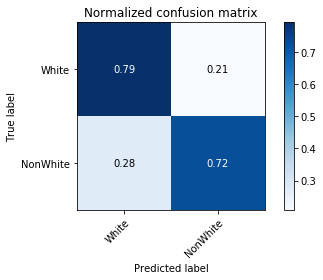

In [12]:
explore_data.plot_confusion_matrix(val_target, val_preds_mlp_ngram, classes, normalize=True)

Confusion matrix, without normalization
[[23357  8063]
 [ 8660 22760]]
              precision    recall  f1-score   support

       White       0.73      0.74      0.74     31420
    NonWhite       0.74      0.72      0.73     31420

   micro avg       0.73      0.73      0.73     62840
   macro avg       0.73      0.73      0.73     62840
weighted avg       0.73      0.73      0.73     62840



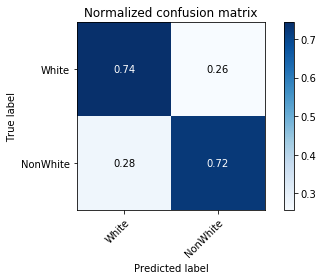

In [47]:
explore_data.plot_confusion_matrix(val_target, val_preds_cnn, classes, normalize=True)

Confusion matrix, without normalization
[[23522  7898]
 [ 8185 23235]]
              precision    recall  f1-score   support

       White       0.74      0.75      0.75     31420
    NonWhite       0.75      0.74      0.74     31420

   micro avg       0.74      0.74      0.74     62840
   macro avg       0.74      0.74      0.74     62840
weighted avg       0.74      0.74      0.74     62840



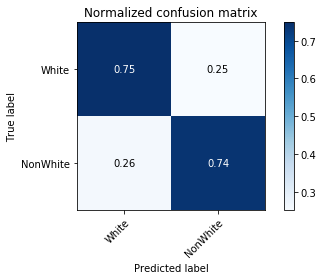

In [48]:
explore_data.plot_confusion_matrix(val_target, val_preds_cnn_aggr_chunk, classes, normalize=True)

In [13]:
descr_df = pd.read_csv(main_dir+'final-project/data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.reset_index(inplace=True)
descr_df.shape

/usr/local/lib/python3.5/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(62840, 17)

In [15]:
descr_df.head()

,speech_id,date,char_count,word_count,speakerid,Party,Congress,Chamber,State,Ethnicity,Age,Age_lt_med,NonWhite,Female,speaker,Full Name,match
0,1010243717,19901025,870,166,101110870.0,D,101,H,TX,B,49.0,1.0,1.0,0.0,Mr. WASHINGTON,"WASHINGTON, CRAIG",exact
1,1120097305,20120416,1186,197,112116570.0,R,112,H,OH,AAPIA,54.0,1.0,1.0,0.0,Mr. AUSTRIA,"AUSTRIA, STEVE",fuzzy
2,1020183502,19920630,257,40,102111850.0,D,102,H,TX,H,76.0,0.0,1.0,0.0,Mr. GONZALEZ,"GONZALEZ, HENRY",exact
3,1080187463,20041001,2689,420,108115260.0,D,108,H,MD,B,53.0,1.0,1.0,0.0,Mr. WYNN,"WYNN, ALBERT",fuzzy
4,1090010764,20050309,7723,1156,109116411.0,D,109,S,HI,AAPIA,82.0,0.0,1.0,0.0,Mr. AKAKA,"AKAKA, DANIEL",exact


In [14]:
pred_df = pd.DataFrame({'ids': np.asarray(val_ids, dtype=np.int64), 
                        'pred_probs_mlp_ngram': val_pred_probs_mlp_ngram.flatten(), 
                        'pred_probs_cnn': val_pred_probs_cnn.flatten(),
                        'pred_probs_cnn_chunk': val_pred_probs_cnn_aggr_chunk.flatten()})
pred_df.shape

(62840, 4)

In [17]:
pred_df.head()

,ids,pred_probs_cnn,pred_probs_cnn_chunk,pred_probs_mlp_ngram
0,1010243717,0.689634,0.447245,0.564903
1,1120097305,0.811908,0.662056,0.971263
2,1020183502,0.401432,0.576263,0.314850
3,1080187463,0.422509,0.464190,0.964284
4,1090010764,0.748211,0.577205,0.918813


In [18]:
descr_pred_df = descr_df.merge(pred_df, left_on='speech_id', right_on='ids')
descr_pred_df.shape

(62840, 21)

In [19]:
preds = [
    'pred_probs_mlp_ngram',
    'pred_probs_cnn', 
    'pred_probs_cnn_chunk'
]

In [20]:
descr_pred_df[preds+['Ethnicity']].groupby('Ethnicity').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
Ethnicity,,,
AAPIA,0.632783,0.620828,0.578595
B,0.726586,0.686365,0.614533
B/AAPIA,0.674774,0.673449,0.607783
B/H,0.733481,0.685009,0.612175
H,0.663007,0.652012,0.593871
H/ME,0.276538,0.295826,0.396610
ME,0.565193,0.532540,0.518381
W,0.307530,0.354303,0.422798


In [21]:
descr_pred_df[preds+['NonWhite']].groupby('NonWhite').mean()

,pred_probs_mlp_ngram,pred_probs_cnn,pred_probs_cnn_chunk
NonWhite,,,
0.0,0.307530,0.354303,0.422798
1.0,0.677663,0.650178,0.593078


In [23]:
preds_combo = []
for i in range(1, len(preds)+1):
    preds_combo.extend(list(itertools.combinations(preds, i)))
len(preds_combo)

7

In [24]:
preds_combo_results = []
for i in range(len(preds_combo)):
    temp = descr_pred_df[list(preds_combo[i])]
    avg = temp.mean(axis=1)
    avg_pred = avg > 0.5
    result = np.mean(avg_pred==descr_pred_df['NonWhite'])
    preds_combo_results.append((preds_combo[i], result))

In [25]:
preds_combo_results = sorted(preds_combo_results, key=lambda x: -x[1])
preds_combo_results

[(('pred_probs_mlp_ngram', 'pred_probs_cnn', 'pred_probs_cnn_chunk'),
  0.7658020369191598),
 (('pred_probs_mlp_ngram', 'pred_probs_cnn_chunk'), 0.764417568427753),
 (('pred_probs_mlp_ngram', 'pred_probs_cnn'), 0.7631444939528963),
 (('pred_probs_mlp_ngram',), 0.7561744112030554),
 (('pred_probs_cnn', 'pred_probs_cnn_chunk'), 0.7464831317632081),
 (('pred_probs_cnn_chunk',), 0.7440642902609803),
 (('pred_probs_cnn',), 0.7338796944621261)]

In [26]:
descr_pred_df['pred_probs_combo'] = descr_pred_df[list(preds_combo_results[0][0])].mean(axis=1)
descr_pred_df['pred_combo'] = descr_pred_df['pred_probs_combo'] > 0.5
np.mean(val_target==descr_pred_df['pred_combo'].values.flatten())

0.7658020369191598

### Save the main dataframe

In [67]:
keep_cols = ['speech_id',
 'date',
 'char_count',
 'word_count',
 'speakerid',
 'Party',
 'Congress',
 'Chamber',
 'State',
 'Ethnicity',
 'Age',
 'Age_lt_med',
 'NonWhite',
 'Female',
 'speaker',
 'Full Name',
 'match',
 'ids',
 'pred_probs_combo',
 'pred_combo']

In [68]:
descr_pred_df[keep_cols].to_pickle(os.path.join(probs_path, 'ethnicity_preds.pkl'))

### Evaluating final predictions

Confusion matrix, without normalization
[[24725  6695]
 [ 8022 23398]]
              precision    recall  f1-score   support

       White       0.76      0.79      0.77     31420
    NonWhite       0.78      0.74      0.76     31420

   micro avg       0.77      0.77      0.77     62840
   macro avg       0.77      0.77      0.77     62840
weighted avg       0.77      0.77      0.77     62840



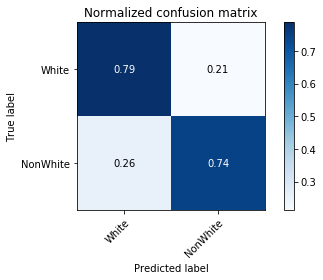

In [27]:
explore_data.plot_confusion_matrix(val_target, descr_pred_df['pred_combo'], classes, normalize=True)

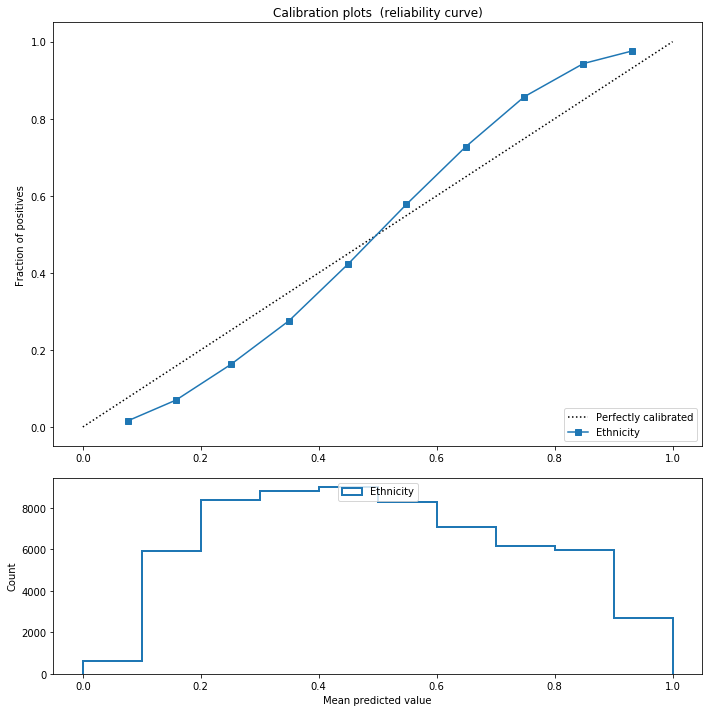

In [28]:
explore_data.plot_calibration_curve(val_target, descr_pred_df['pred_probs_combo'], 'Ethnicity')

In [29]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(descr_pred_df['pred_probs_combo'], 
                                   val_ids, 
                                   descr_df.set_index('speech_id'))

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base  0.175939            0.5  58.427562  0.690738   0.694876    376.978469


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.37,0.36,1.00,0.75,0.59,1.10
0.6,0.86,0.99,0.99,1.00,1.19,0.85
1.0,1.79,1.71,1.01,1.27,1.30,1.01


In [69]:
reload(explore_data)
explore_data.compare_ngrams(val_list, descr_pred_df['pred_probs_combo'], 
                            ngram_range=(1, 1),
                            top_k=20)


Top 20 ngrams by differentiating score:


,ngram,<0.4,<0.6,<1.0,score
0,black,338.0,403.0,5690.0,664.0
1,african,105.0,234.0,3331.0,484.0
2,consume,334.0,1053.0,1659.0,482.0
3,caucus,283.0,225.0,2329.0,440.0
4,printed,1653.0,473.0,332.0,394.0
5,senators,4080.0,991.0,1129.0,383.0
6,civil,1103.0,1203.0,4150.0,331.0
7,honor,1805.0,1564.0,3921.0,329.0
8,city,1975.0,1670.0,5438.0,319.0
9,congressional,2285.0,1618.0,4872.0,319.0


## Congressperson level analysis

In [55]:
speaker_df = descr_pred_df[['Full Name', 'Party', 'State', 'Female', 'NonWhite', 'Age', 'pred_probs_combo']]\
                .groupby(['Full Name', 'Party', 'State', 'Female', 'NonWhite'])\
                .agg({'pred_probs_combo':['mean', 'count'], 'Age': ['mean']})\
                .reset_index()
speaker_df.columns = ['_'.join(col) for col in speaker_df.columns]
speaker_df['NonWhite_pred_'] = speaker_df.pred_probs_combo_mean > 0.5
speaker_df.shape

(1702, 9)

Confusion matrix, without normalization
[[1168  307]
 [  25  202]]
              precision    recall  f1-score   support

       White       0.98      0.79      0.88      1475
    NonWhite       0.40      0.89      0.55       227

   micro avg       0.80      0.80      0.80      1702
   macro avg       0.69      0.84      0.71      1702
weighted avg       0.90      0.80      0.83      1702



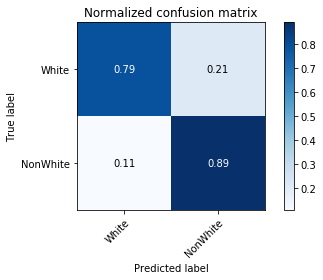

In [56]:
explore_data.plot_confusion_matrix(speaker_df.NonWhite_, speaker_df.NonWhite_pred_, classes, normalize=True)

In [47]:
speaker_df.pred_probs_combo_count.median()

11.0

In [57]:
speaker_med_df = speaker_df[speaker_df.pred_probs_combo_count > speaker_df.pred_probs_combo_count.median()]
speaker_med_df.shape

(844, 9)

Confusion matrix, without normalization
[[570  72]
 [ 22 180]]
              precision    recall  f1-score   support

       White       0.96      0.89      0.92       642
    NonWhite       0.71      0.89      0.79       202

   micro avg       0.89      0.89      0.89       844
   macro avg       0.84      0.89      0.86       844
weighted avg       0.90      0.89      0.89       844



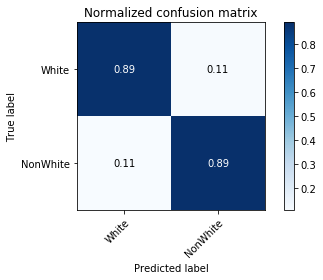

In [49]:
explore_data.plot_confusion_matrix(speaker_med_df.NonWhite_, speaker_med_df.NonWhite_pred_, classes, normalize=True)

In [58]:
tp = np.argmax(speaker_med_df[speaker_med_df.NonWhite_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite_==1].iloc[tp]

Full Name_                JEFFRIES, HAKEEM
Party_                                   D
State_                                  NY
Female_                                  0
NonWhite_                                1
pred_probs_combo_mean             0.818035
pred_probs_combo_count                  88
Age_mean                           44.6136
NonWhite_pred_                        True
Name: 806, dtype: object

In [59]:
tn = np.argmin(speaker_med_df[speaker_med_df.NonWhite_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite_==0].iloc[tn]

Full Name_                CORKER, BOB
Party_                              R
State_                             TN
Female_                             0
NonWhite_                           0
pred_probs_combo_mean        0.181517
pred_probs_combo_count             12
Age_mean                      59.6667
NonWhite_pred_                  False
Name: 336, dtype: object

In [60]:
fp = np.argmax(speaker_med_df[speaker_med_df.NonWhite_==0].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite_==0].iloc[fp]

Full Name_                BORDALLO, MADELEINE
Party_                                      D
State_                                     GU
Female_                                     1
NonWhite_                                   0
pred_probs_combo_mean                0.736579
pred_probs_combo_count                     20
Age_mean                                 75.4
NonWhite_pred_                           True
Name: 150, dtype: object

In [61]:
fn = np.argmin(speaker_med_df[speaker_med_df.NonWhite_==1].pred_probs_combo_mean.values)
speaker_med_df[speaker_med_df.NonWhite_==1].iloc[fn]

Full Name_                ABDNOR, JAMES
Party_                                R
State_                               SD
Female_                               0
NonWhite_                             1
pred_probs_combo_mean            0.2952
pred_probs_combo_count              180
Age_mean                        61.5444
NonWhite_pred_                    False
Name: 0, dtype: object

## Congress level analysis

In [62]:
congress_df = descr_pred_df[['Congress', 'NonWhite', 'pred_probs_combo', 'pred_combo']]\
                .groupby('Congress')\
                .agg({'NonWhite': ['mean', 'sum'], 'pred_combo': ['mean']})\
                .reset_index()
congress_df.columns = ['_'.join(col) for col in congress_df.columns]
congress_df['Prediction_balance'] = congress_df.pred_combo_mean / congress_df.NonWhite_mean
congress_df.shape

(18, 5)

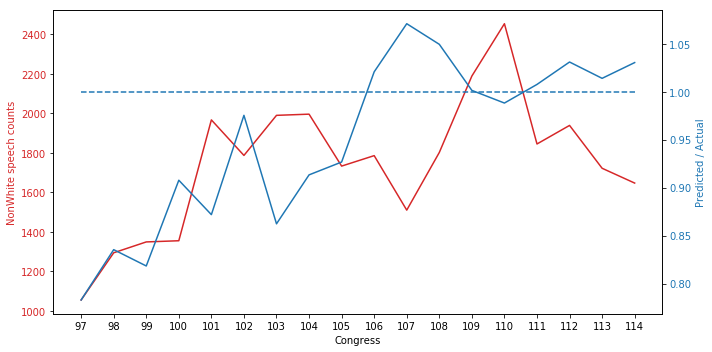

In [66]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Congress')
ax1.set_ylabel('NonWhite speech counts', color=color)
ax1.plot(congress_df.Congress_, congress_df.NonWhite_sum, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Predicted / Actual', color=color)  # we already handled the x-label with ax1
ax2.plot(congress_df.Congress_, congress_df.Prediction_balance, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.hlines(y=1,xmin=97,xmax=114, color=color, linestyles='dashed')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(range(97,115))
plt.show()